In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers


2024-01-03 15:04:32.571482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
import calendar

In [3]:
# Define domain and time period
start_lat = 12 # 5 
end_lat = 17 #10
start_lon = -17 #-10
end_lon = -12 #0
start_year = '2010'
start_month = '06'
end_year = '2010'
end_month = '09'
start_day = '01'
end_day = '30'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
#reg_lat = np.arange(start_lat, end_lat, 0.04)
#reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [4]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values


In [5]:
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)

cores = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*96)) #using every fourth value for hourly comparison- 24hr

In [6]:
# read in input data- TIR and historical core data at t<to
#core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
#ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
#cores = ds['msg_cores'].values# uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
#tir = ds['msg_Tir'].values/10000 # uint.interpolate_data(ds['tir'].values, inds, weights, shape)  # interpolation using saved weights for MSG TIR          
#time_core = ds['time']# (core_filename[-15:-3])


In [7]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
            list_of_file_names.append(all_file_names) # all days in month
        #if os.path.isfile(all_file_names):      
         #   list_of_file_names.append(all_file_names) # all days in month
        #else:
         #   list_of_file_names.append('file_not_available') # all days in month
            #print(all_file_names)
             
elif int(start_year)<int(end_year):
    y=1
    for i in range(int(start_year),int(end_year)+1,1):
        if y==1:
            for m in range(int(start_month),10,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                #for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
            #print((all_file_names))
                #print(len(all_file_names))
                y=y+1
                month=[]
            
        else:
            for m in range(1,int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)    
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
#if int(start_year)<int(end_year):
 #   list_of_files = list_of_files[0]+list_of_files[1]
#else:
   # list_of_files = list_of_files[0]#+list_of_files[1]    
print(len(list_of_files))

11712


In [8]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = str(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010000.nc
0
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010015.nc
1
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010030.nc
2
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010045.nc
3
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010100.nc
4
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010115.nc
5
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010130.nc
6
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010145.nc
7
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010200.nc
8
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010215.nc
9
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010230.nc
10
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010245.nc
11
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010300.nc
12
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010315.nc
13
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010330.nc
14
/prj/

123
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020700.nc
124
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020715.nc
125
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020730.nc
126
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020745.nc
127
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020800.nc
128
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020815.nc
129
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020830.nc
130
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020845.nc
131
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020900.nc
132
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020915.nc
133
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020930.nc
134
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020945.nc
135
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006021000.nc
136
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006021015.nc
137
/prj/nflics/hist_cores/2010/06/02/Hist_cores

244
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031315.nc
245
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031330.nc
246
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031345.nc
247
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031400.nc
248
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031415.nc
249
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031430.nc
250
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031445.nc
251
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031500.nc
252
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031515.nc
253
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031530.nc
254
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031545.nc
255
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031600.nc
256
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031615.nc
257
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031630.nc
258
/prj/nflics/hist_cores/2010/06/03/Hist_cores

366
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006041945.nc
367
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042000.nc
368
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042015.nc
369
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042030.nc
370
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042045.nc
371
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042100.nc
372
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042115.nc
373
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042130.nc
374
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042145.nc
375
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042200.nc
376
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042215.nc
377
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042230.nc
378
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042245.nc
379
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042300.nc
380
/prj/nflics/hist_cores/2010/06/04/Hist_cores

489
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060230.nc
490
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060245.nc
491
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060300.nc
492
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060315.nc
493
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060330.nc
494
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060345.nc
495
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060400.nc
496
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060415.nc
497
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060430.nc
498
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060445.nc
499
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060500.nc
500
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060515.nc
501
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060530.nc
502
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060545.nc
503
/prj/nflics/hist_cores/2010/06/06/Hist_cores

611
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070900.nc
612
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070915.nc
613
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070930.nc
614
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070945.nc
615
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071000.nc
616
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071015.nc
617
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071030.nc
618
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071045.nc
619
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071100.nc
620
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071115.nc
621
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071130.nc
622
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071145.nc
623
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071200.nc
624
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071215.nc
625
/prj/nflics/hist_cores/2010/06/07/Hist_cores

/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081515.nc
733
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081530.nc
734
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081545.nc
735
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081600.nc
736
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081615.nc
737
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081630.nc
738
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081645.nc
739
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081700.nc
740
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081715.nc
741
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081730.nc
742
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081745.nc
743
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081800.nc
744
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081815.nc
745
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081830.nc
746
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_

855
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092200.nc
856
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092215.nc
857
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092230.nc
858
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092245.nc
859
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092300.nc
860
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092315.nc
861
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092330.nc
862
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092345.nc
863
/prj/nflics/hist_cores/2010/06/10/Hist_cores_wa_201006100000.nc
864
/prj/nflics/hist_cores/2010/06/10/Hist_cores_wa_201006100015.nc
865
/prj/nflics/hist_cores/2010/06/10/Hist_cores_wa_201006100030.nc
866
/prj/nflics/hist_cores/2010/06/10/Hist_cores_wa_201006100045.nc
867
/prj/nflics/hist_cores/2010/06/10/Hist_cores_wa_201006100100.nc
868
/prj/nflics/hist_cores/2010/06/10/Hist_cores_wa_201006100115.nc
869
/prj/nflics/hist_cores/2010/06/10/Hist_cores

/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110430.nc
978
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110445.nc
979
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110500.nc
980
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110515.nc
981
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110530.nc
982
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110545.nc
983
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110600.nc
984
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110615.nc
985
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110630.nc
986
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110645.nc
987
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110700.nc
988
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110715.nc
989
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110730.nc
990
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110745.nc
991
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_

/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121030.nc
1098
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121045.nc
1099
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121100.nc
1100
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121115.nc
1101
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121130.nc
1102
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121145.nc
1103
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121200.nc
1104
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121215.nc
1105
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121230.nc
1106
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121245.nc
1107
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121300.nc
1108
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121315.nc
1109
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121330.nc
1110
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121345.nc
1111
/prj/nflics/hist_cores/2010/06/12/

/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131615.nc
1217
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131630.nc
1218
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131645.nc
1219
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131700.nc
1220
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131715.nc
1221
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131730.nc
1222
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131745.nc
1223
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131800.nc
1224
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131815.nc
1225
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131830.nc
1226
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131845.nc
1227
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131900.nc
1228
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131915.nc
1229
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131930.nc
1230
/prj/nflics/hist_cores/2010/06/13/

1336
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142215.nc
1337
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142230.nc
1338
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142245.nc
1339
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142300.nc
1340
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142315.nc
1341
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142330.nc
1342
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142345.nc
1343
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150000.nc
1344
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150015.nc
1345
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150030.nc
1346
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150045.nc
1347
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150100.nc
1348
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150115.nc
1349
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150130.nc
1350
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160415.nc
1457
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160430.nc
1458
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160445.nc
1459
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160500.nc
1460
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160515.nc
1461
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160530.nc
1462
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160545.nc
1463
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160600.nc
1464
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160615.nc
1465
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160630.nc
1466
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160645.nc
1467
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160700.nc
1468
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160715.nc
1469
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160730.nc
1470
/prj/nflics/hist_cores/2010/06/16/

1575
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171000.nc
1576
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171015.nc
1577
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171030.nc
1578
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171045.nc
1579
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171100.nc
1580
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171115.nc
1581
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171130.nc
1582
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171145.nc
1583
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171200.nc
1584
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171215.nc
1585
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171230.nc
1586
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171245.nc
1587
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171300.nc
1588
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171315.nc
1589
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181545.nc
1695
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181600.nc
1696
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181615.nc
1697
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181630.nc
1698
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181645.nc
1699
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181700.nc
1700
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181715.nc
1701
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181730.nc
1702
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181745.nc
1703
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181800.nc
1704
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181815.nc
1705
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181830.nc
1706
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181845.nc
1707
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181900.nc
1708
/prj/nflics/hist_cores/2010/06/18/

/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192130.nc
1814
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192145.nc
1815
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192200.nc
1816
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192215.nc
1817
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192230.nc
1818
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192245.nc
1819
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192300.nc
1820
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192315.nc
1821
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192330.nc
1822
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192345.nc
1823
/prj/nflics/hist_cores/2010/06/20/Hist_cores_wa_201006200000.nc
1824
/prj/nflics/hist_cores/2010/06/20/Hist_cores_wa_201006200015.nc
1825
/prj/nflics/hist_cores/2010/06/20/Hist_cores_wa_201006200030.nc
1826
/prj/nflics/hist_cores/2010/06/20/Hist_cores_wa_201006200045.nc
1827
/prj/nflics/hist_cores/2010/06/20/

1933
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210330.nc
1934
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210345.nc
1935
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210400.nc
1936
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210415.nc
1937
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210430.nc
1938
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210445.nc
1939
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210500.nc
1940
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210515.nc
1941
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210530.nc
1942
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210545.nc
1943
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210600.nc
1944
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210615.nc
1945
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210630.nc
1946
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210645.nc
1947
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220915.nc
2053
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220930.nc
2054
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220945.nc
2055
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221000.nc
2056
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221015.nc
2057
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221030.nc
2058
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221045.nc
2059
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221100.nc
2060
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221115.nc
2061
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221130.nc
2062
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221145.nc
2063
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221200.nc
2064
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221215.nc
2065
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221230.nc
2066
/prj/nflics/hist_cores/2010/06/22/

/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231500.nc
2172
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231515.nc
2173
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231530.nc
2174
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231545.nc
2175
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231600.nc
2176
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231615.nc
2177
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231630.nc
2178
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231645.nc
2179
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231700.nc
2180
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231715.nc
2181
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231730.nc
2182
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231745.nc
2183
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231800.nc
2184
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231815.nc
2185
/prj/nflics/hist_cores/2010/06/23/

/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242045.nc
2291
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242100.nc
2292
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242115.nc
2293
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242130.nc
2294
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242145.nc
2295
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242200.nc
2296
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242215.nc
2297
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242230.nc
2298
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242245.nc
2299
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242300.nc
2300
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242315.nc
2301
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242330.nc
2302
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242345.nc
2303
/prj/nflics/hist_cores/2010/06/25/Hist_cores_wa_201006250000.nc
2304
/prj/nflics/hist_cores/2010/06/25/

/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260300.nc
2412
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260315.nc
2413
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260330.nc
2414
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260345.nc
2415
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260400.nc
2416
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260415.nc
2417
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260430.nc
2418
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260445.nc
2419
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260500.nc
2420
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260515.nc
2421
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260530.nc
2422
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260545.nc
2423
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260600.nc
2424
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260615.nc
2425
/prj/nflics/hist_cores/2010/06/26/

2531
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270900.nc
2532
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270915.nc
2533
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270930.nc
2534
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270945.nc
2535
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271000.nc
2536
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271015.nc
2537
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271030.nc
2538
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271045.nc
2539
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271100.nc
2540
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271115.nc
2541
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271130.nc
2542
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271145.nc
2543
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271200.nc
2544
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271215.nc
2545
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281500.nc
2652
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281515.nc
2653
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281530.nc
2654
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281545.nc
2655
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281600.nc
2656
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281615.nc
2657
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281630.nc
2658
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281645.nc
2659
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281700.nc
2660
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281715.nc
2661
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281730.nc
2662
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281745.nc
2663
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281800.nc
2664
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281815.nc
2665
/prj/nflics/hist_cores/2010/06/28/

2770
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292045.nc
2771
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292100.nc
2772
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292115.nc
2773
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292130.nc
2774
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292145.nc
2775
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292200.nc
2776
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292215.nc
2777
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292230.nc
2778
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292245.nc
2779
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292300.nc
2780
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292315.nc
2781
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292330.nc
2782
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292345.nc
2783
/prj/nflics/hist_cores/2010/06/30/Hist_cores_wa_201006300000.nc
2784
/prj/nflics/hist_cores/2010/0

2890
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010245.nc
2891
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010300.nc
2892
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010315.nc
2893
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010330.nc
2894
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010345.nc
2895
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010400.nc
2896
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010415.nc
2897
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010430.nc
2898
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010445.nc
2899
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010500.nc
2900
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010515.nc
2901
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010530.nc
2902
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010545.nc
2903
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010600.nc
2904
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020900.nc
3012
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020915.nc
3013
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020930.nc
3014
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020945.nc
3015
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021000.nc
3016
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021015.nc
3017
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021030.nc
3018
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021045.nc
3019
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021100.nc
3020
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021115.nc
3021
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021130.nc
3022
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021145.nc
3023
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021200.nc
3024
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021215.nc
3025
/prj/nflics/hist_cores/2010/07/02/

3130
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031445.nc
3131
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031500.nc
3132
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031515.nc
3133
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031530.nc
3134
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031545.nc
3135
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031600.nc
3136
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031615.nc
3137
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031630.nc
3138
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031645.nc
3139
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031700.nc
3140
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031715.nc
3141
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031730.nc
3142
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031745.nc
3143
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031800.nc
3144
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042045.nc
3251
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042100.nc
3252
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042115.nc
3253
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042130.nc
3254
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042145.nc
3255
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042200.nc
3256
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042215.nc
3257
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042230.nc
3258
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042245.nc
3259
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042300.nc
3260
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042315.nc
3261
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042330.nc
3262
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042345.nc
3263
/prj/nflics/hist_cores/2010/07/05/Hist_cores_wa_201007050000.nc
3264
/prj/nflics/hist_cores/2010/07/05/

/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060245.nc
3371
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060300.nc
3372
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060315.nc
3373
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060330.nc
3374
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060345.nc
3375
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060400.nc
3376
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060415.nc
3377
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060430.nc
3378
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060445.nc
3379
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060500.nc
3380
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060515.nc
3381
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060530.nc
3382
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060545.nc
3383
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060600.nc
3384
/prj/nflics/hist_cores/2010/07/06/

/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070900.nc
3492
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070915.nc
3493
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070930.nc
3494
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070945.nc
3495
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071000.nc
3496
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071015.nc
3497
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071030.nc
3498
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071045.nc
3499
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071100.nc
3500
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071115.nc
3501
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071130.nc
3502
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071145.nc
3503
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071200.nc
3504
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071215.nc
3505
/prj/nflics/hist_cores/2010/07/07/

/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081500.nc
3612
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081515.nc
3613
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081530.nc
3614
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081545.nc
3615
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081600.nc
3616
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081615.nc
3617
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081630.nc
3618
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081645.nc
3619
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081700.nc
3620
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081715.nc
3621
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081730.nc
3622
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081745.nc
3623
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081800.nc
3624
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081815.nc
3625
/prj/nflics/hist_cores/2010/07/08/

/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092100.nc
3732
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092115.nc
3733
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092130.nc
3734
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092145.nc
3735
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092200.nc
3736
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092215.nc
3737
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092230.nc
3738
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092245.nc
3739
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092300.nc
3740
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092315.nc
3741
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092330.nc
3742
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092345.nc
3743
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100000.nc
3744
/prj/nflics/hist_cores/2010/07/10/Hist_cores_wa_201007100015.nc
3745
/prj/nflics/hist_cores/2010/07/10/

3852
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110315.nc
3853
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110330.nc
3854
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110345.nc
3855
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110400.nc
3856
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110415.nc
3857
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110430.nc
3858
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110445.nc
3859
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110500.nc
3860
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110515.nc
3861
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110530.nc
3862
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110545.nc
3863
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110600.nc
3864
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110615.nc
3865
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110630.nc
3866
/prj/nflics/hist_cores/2010/0

3973
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120930.nc
3974
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120945.nc
3975
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121000.nc
3976
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121015.nc
3977
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121030.nc
3978
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121045.nc
3979
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121100.nc
3980
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121115.nc
3981
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121130.nc
3982
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121145.nc
3983
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121200.nc
3984
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121215.nc
3985
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121230.nc
3986
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121245.nc
3987
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131530.nc
4094
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131545.nc
4095
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131600.nc
4096
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131615.nc
4097
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131630.nc
4098
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131645.nc
4099
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131700.nc
4100
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131715.nc
4101
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131730.nc
4102
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131745.nc
4103
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131800.nc
4104
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131815.nc
4105
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131830.nc
4106
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131845.nc
4107
/prj/nflics/hist_cores/2010/07/13/

4212
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142115.nc
4213
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142130.nc
4214
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142145.nc
4215
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142200.nc
4216
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142215.nc
4217
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142230.nc
4218
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142245.nc
4219
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142300.nc
4220
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142315.nc
4221
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142330.nc
4222
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142345.nc
4223
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150000.nc
4224
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150015.nc
4225
/prj/nflics/hist_cores/2010/07/15/Hist_cores_wa_201007150030.nc
4226
/prj/nflics/hist_cores/2010/0

4333
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160330.nc
4334
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160345.nc
4335
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160400.nc
4336
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160415.nc
4337
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160430.nc
4338
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160445.nc
4339
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160500.nc
4340
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160515.nc
4341
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160530.nc
4342
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160545.nc
4343
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160600.nc
4344
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160615.nc
4345
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160630.nc
4346
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160645.nc
4347
/prj/nflics/hist_cores/2010/0

4454
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170945.nc
4455
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171000.nc
4456
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171015.nc
4457
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171030.nc
4458
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171045.nc
4459
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171100.nc
4460
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171115.nc
4461
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171130.nc
4462
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171145.nc
4463
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171200.nc
4464
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171215.nc
4465
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171230.nc
4466
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171245.nc
4467
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171300.nc
4468
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181545.nc
4575
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181600.nc
4576
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181615.nc
4577
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181630.nc
4578
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181645.nc
4579
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181700.nc
4580
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181715.nc
4581
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181730.nc
4582
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181745.nc
4583
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181800.nc
4584
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181815.nc
4585
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181830.nc
4586
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181845.nc
4587
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181900.nc
4588
/prj/nflics/hist_cores/2010/07/18/

4694
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192145.nc
4695
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192200.nc
4696
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192215.nc
4697
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192230.nc
4698
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192245.nc
4699
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192300.nc
4700
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192315.nc
4701
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192330.nc
4702
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192345.nc
4703
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200000.nc
4704
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200015.nc
4705
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200030.nc
4706
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200045.nc
4707
/prj/nflics/hist_cores/2010/07/20/Hist_cores_wa_201007200100.nc
4708
/prj/nflics/hist_cores/2010/0

4814
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210345.nc
4815
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210400.nc
4816
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210415.nc
4817
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210430.nc
4818
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210445.nc
4819
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210500.nc
4820
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210515.nc
4821
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210530.nc
4822
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210545.nc
4823
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210600.nc
4824
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210615.nc
4825
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210630.nc
4826
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210645.nc
4827
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210700.nc
4828
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220930.nc
4934
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220945.nc
4935
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221000.nc
4936
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221015.nc
4937
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221030.nc
4938
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221045.nc
4939
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221100.nc
4940
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221115.nc
4941
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221130.nc
4942
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221145.nc
4943
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221200.nc
4944
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221215.nc
4945
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221230.nc
4946
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007221245.nc
4947
/prj/nflics/hist_cores/2010/07/22/

/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231530.nc
5054
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231545.nc
5055
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231600.nc
5056
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231615.nc
5057
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231630.nc
5058
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231645.nc
5059
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231700.nc
5060
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231715.nc
5061
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231730.nc
5062
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231745.nc
5063
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231800.nc
5064
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231815.nc
5065
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231830.nc
5066
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231845.nc
5067
/prj/nflics/hist_cores/2010/07/23/

5174
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242145.nc
5175
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242200.nc
5176
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242215.nc
5177
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242230.nc
5178
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242245.nc
5179
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242300.nc
5180
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242315.nc
5181
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242330.nc
5182
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242345.nc
5183
/prj/nflics/hist_cores/2010/07/25/Hist_cores_wa_201007250000.nc
5184
/prj/nflics/hist_cores/2010/07/25/Hist_cores_wa_201007250015.nc
5185
/prj/nflics/hist_cores/2010/07/25/Hist_cores_wa_201007250030.nc
5186
/prj/nflics/hist_cores/2010/07/25/Hist_cores_wa_201007250045.nc
5187
/prj/nflics/hist_cores/2010/07/25/Hist_cores_wa_201007250100.nc
5188
/prj/nflics/hist_cores/2010/0

5294
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260345.nc
5295
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260400.nc
5296
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260415.nc
5297
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260430.nc
5298
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260445.nc
5299
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260500.nc
5300
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260515.nc
5301
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260530.nc
5302
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260545.nc
5303
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260600.nc
5304
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260615.nc
5305
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260630.nc
5306
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260645.nc
5307
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260700.nc
5308
/prj/nflics/hist_cores/2010/0

5413
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270930.nc
5414
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270945.nc
5415
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271000.nc
5416
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271015.nc
5417
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271030.nc
5418
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271045.nc
5419
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271100.nc
5420
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271115.nc
5421
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271130.nc
5422
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271145.nc
5423
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271200.nc
5424
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271215.nc
5425
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271230.nc
5426
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007271245.nc
5427
/prj/nflics/hist_cores/2010/0

5533
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281530.nc
5534
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281545.nc
5535
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281600.nc
5536
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281615.nc
5537
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281630.nc
5538
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281645.nc
5539
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281700.nc
5540
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281715.nc
5541
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281730.nc
5542
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281745.nc
5543
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281800.nc
5544
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281815.nc
5545
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281830.nc
5546
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281845.nc
5547
/prj/nflics/hist_cores/2010/0

5652
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292115.nc
5653
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292130.nc
5654
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292145.nc
5655
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292200.nc
5656
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292215.nc
5657
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292230.nc
5658
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292245.nc
5659
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292300.nc
5660
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292315.nc
5661
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292330.nc
5662
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292345.nc
5663
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007300000.nc
5664
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007300015.nc
5665
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007300030.nc
5666
/prj/nflics/hist_cores/2010/0

5772
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310315.nc
5773
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310330.nc
5774
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310345.nc
5775
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310400.nc
5776
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310415.nc
5777
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310430.nc
5778
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310445.nc
5779
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310500.nc
5780
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310515.nc
5781
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310530.nc
5782
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310545.nc
5783
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310600.nc
5784
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310615.nc
5785
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310630.nc
5786
/prj/nflics/hist_cores/2010/0

5893
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010930.nc
5894
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010945.nc
5895
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011000.nc
5896
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011015.nc
5897
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011030.nc
5898
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011045.nc
5899
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011100.nc
5900
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011115.nc
5901
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011130.nc
5902
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011145.nc
5903
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011200.nc
5904
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011215.nc
5905
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011230.nc
5906
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008011245.nc
5907
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021515.nc
6013
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021530.nc
6014
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021545.nc
6015
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021600.nc
6016
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021615.nc
6017
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021630.nc
6018
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021645.nc
6019
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021700.nc
6020
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021715.nc
6021
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021730.nc
6022
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021745.nc
6023
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021800.nc
6024
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021815.nc
6025
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021830.nc
6026
/prj/nflics/hist_cores/2010/08/02/

/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032100.nc
6132
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032115.nc
6133
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032130.nc
6134
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032145.nc
6135
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032200.nc
6136
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032215.nc
6137
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032230.nc
6138
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032245.nc
6139
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032300.nc
6140
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032315.nc
6141
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032330.nc
6142
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032345.nc
6143
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008040000.nc
6144
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008040015.nc
6145
/prj/nflics/hist_cores/2010/08/04/

6252
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050315.nc
6253
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050330.nc
6254
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050345.nc
6255
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050400.nc
6256
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050415.nc
6257
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050430.nc
6258
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050445.nc
6259
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050500.nc
6260
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050515.nc
6261
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050530.nc
6262
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050545.nc
6263
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050600.nc
6264
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050615.nc
6265
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050630.nc
6266
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060900.nc
6372
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060915.nc
6373
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060930.nc
6374
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060945.nc
6375
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061000.nc
6376
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061015.nc
6377
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061030.nc
6378
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061045.nc
6379
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061100.nc
6380
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061115.nc
6381
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061130.nc
6382
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061145.nc
6383
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061200.nc
6384
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008061215.nc
6385
/prj/nflics/hist_cores/2010/08/06/

6491
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071500.nc
6492
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071515.nc
6493
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071530.nc
6494
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071545.nc
6495
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071600.nc
6496
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071615.nc
6497
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071630.nc
6498
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071645.nc
6499
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071700.nc
6500
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071715.nc
6501
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071730.nc
6502
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071745.nc
6503
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071800.nc
6504
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071815.nc
6505
/prj/nflics/hist_cores/2010/0

6610
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082045.nc
6611
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082100.nc
6612
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082115.nc
6613
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082130.nc
6614
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082145.nc
6615
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082200.nc
6616
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082215.nc
6617
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082230.nc
6618
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082245.nc
6619
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082300.nc
6620
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082315.nc
6621
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082330.nc
6622
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082345.nc
6623
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008090000.nc
6624
/prj/nflics/hist_cores/2010/0

6730
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100245.nc
6731
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100300.nc
6732
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100315.nc
6733
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100330.nc
6734
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100345.nc
6735
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100400.nc
6736
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100415.nc
6737
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100430.nc
6738
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100445.nc
6739
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100500.nc
6740
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100515.nc
6741
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100530.nc
6742
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100545.nc
6743
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100600.nc
6744
/prj/nflics/hist_cores/2010/0

6849
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110830.nc
6850
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110845.nc
6851
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110900.nc
6852
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110915.nc
6853
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110930.nc
6854
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110945.nc
6855
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111000.nc
6856
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111015.nc
6857
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111030.nc
6858
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111045.nc
6859
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111100.nc
6860
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111115.nc
6861
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111130.nc
6862
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008111145.nc
6863
/prj/nflics/hist_cores/2010/0

6970
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121445.nc
6971
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121500.nc
6972
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121515.nc
6973
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121530.nc
6974
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121545.nc
6975
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121600.nc
6976
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121615.nc
6977
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121630.nc
6978
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121645.nc
6979
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121700.nc
6980
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121715.nc
6981
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121730.nc
6982
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121745.nc
6983
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121800.nc
6984
/prj/nflics/hist_cores/2010/0

7089
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132030.nc
7090
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132045.nc
7091
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132100.nc
7092
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132115.nc
7093
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132130.nc
7094
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132145.nc
7095
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132200.nc
7096
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132215.nc
7097
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132230.nc
7098
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132245.nc
7099
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132300.nc
7100
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132315.nc
7101
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132330.nc
7102
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008132345.nc
7103
/prj/nflics/hist_cores/2010/0

7209
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150230.nc
7210
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150245.nc
7211
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150300.nc
7212
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150315.nc
7213
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150330.nc
7214
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150345.nc
7215
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150400.nc
7216
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150415.nc
7217
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150430.nc
7218
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150445.nc
7219
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150500.nc
7220
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150515.nc
7221
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150530.nc
7222
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150545.nc
7223
/prj/nflics/hist_cores/2010/0

7330
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160845.nc
7331
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160900.nc
7332
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160915.nc
7333
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160930.nc
7334
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160945.nc
7335
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161000.nc
7336
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161015.nc
7337
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161030.nc
7338
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161045.nc
7339
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161100.nc
7340
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161115.nc
7341
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161130.nc
7342
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161145.nc
7343
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008161200.nc
7344
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171430.nc
7450
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171445.nc
7451
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171500.nc
7452
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171515.nc
7453
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171530.nc
7454
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171545.nc
7455
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171600.nc
7456
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171615.nc
7457
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171630.nc
7458
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171645.nc
7459
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171700.nc
7460
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171715.nc
7461
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171730.nc
7462
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171745.nc
7463
/prj/nflics/hist_cores/2010/08/17/

/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182015.nc
7569
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182030.nc
7570
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182045.nc
7571
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182100.nc
7572
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182115.nc
7573
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182130.nc
7574
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182145.nc
7575
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182200.nc
7576
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182215.nc
7577
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182230.nc
7578
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182245.nc
7579
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182300.nc
7580
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182315.nc
7581
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008182330.nc
7582
/prj/nflics/hist_cores/2010/08/18/

7689
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200230.nc
7690
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200245.nc
7691
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200300.nc
7692
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200315.nc
7693
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200330.nc
7694
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200345.nc
7695
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200400.nc
7696
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200415.nc
7697
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200430.nc
7698
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200445.nc
7699
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200500.nc
7700
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200515.nc
7701
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200530.nc
7702
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200545.nc
7703
/prj/nflics/hist_cores/2010/0

7808
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210815.nc
7809
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210830.nc
7810
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210845.nc
7811
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210900.nc
7812
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210915.nc
7813
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210930.nc
7814
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210945.nc
7815
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211000.nc
7816
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211015.nc
7817
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211030.nc
7818
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211045.nc
7819
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211100.nc
7820
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211115.nc
7821
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008211130.nc
7822
/prj/nflics/hist_cores/2010/0

7928
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221415.nc
7929
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221430.nc
7930
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221445.nc
7931
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221500.nc
7932
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221515.nc
7933
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221530.nc
7934
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221545.nc
7935
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221600.nc
7936
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221615.nc
7937
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221630.nc
7938
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221645.nc
7939
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221700.nc
7940
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221715.nc
7941
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221730.nc
7942
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232000.nc
8048
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232015.nc
8049
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232030.nc
8050
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232045.nc
8051
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232100.nc
8052
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232115.nc
8053
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232130.nc
8054
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232145.nc
8055
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232200.nc
8056
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232215.nc
8057
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232230.nc
8058
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232245.nc
8059
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232300.nc
8060
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008232315.nc
8061
/prj/nflics/hist_cores/2010/08/23/

8167
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250200.nc
8168
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250215.nc
8169
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250230.nc
8170
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250245.nc
8171
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250300.nc
8172
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250315.nc
8173
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250330.nc
8174
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250345.nc
8175
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250400.nc
8176
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250415.nc
8177
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250430.nc
8178
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250445.nc
8179
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250500.nc
8180
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250515.nc
8181
/prj/nflics/hist_cores/2010/0

8286
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260745.nc
8287
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260800.nc
8288
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260815.nc
8289
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260830.nc
8290
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260845.nc
8291
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260900.nc
8292
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260915.nc
8293
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260930.nc
8294
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260945.nc
8295
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261000.nc
8296
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261015.nc
8297
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261030.nc
8298
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261045.nc
8299
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008261100.nc
8300
/prj/nflics/hist_cores/2010/0

8405
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271330.nc
8406
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271345.nc
8407
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271400.nc
8408
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271415.nc
8409
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271430.nc
8410
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271445.nc
8411
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271500.nc
8412
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271515.nc
8413
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271530.nc
8414
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271545.nc
8415
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271600.nc
8416
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271615.nc
8417
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271630.nc
8418
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271645.nc
8419
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281930.nc
8526
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281945.nc
8527
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282000.nc
8528
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282015.nc
8529
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282030.nc
8530
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282045.nc
8531
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282100.nc
8532
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282115.nc
8533
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282130.nc
8534
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282145.nc
8535
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282200.nc
8536
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282215.nc
8537
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282230.nc
8538
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008282245.nc
8539
/prj/nflics/hist_cores/2010/08/28/

8644
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300115.nc
8645
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300130.nc
8646
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300145.nc
8647
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300200.nc
8648
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300215.nc
8649
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300230.nc
8650
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300245.nc
8651
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300300.nc
8652
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300315.nc
8653
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300330.nc
8654
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300345.nc
8655
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300400.nc
8656
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300415.nc
8657
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300430.nc
8658
/prj/nflics/hist_cores/2010/0

8764
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310715.nc
8765
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310730.nc
8766
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310745.nc
8767
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310800.nc
8768
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310815.nc
8769
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310830.nc
8770
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310845.nc
8771
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310900.nc
8772
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310915.nc
8773
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310930.nc
8774
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310945.nc
8775
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008311000.nc
8776
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008311015.nc
8777
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008311030.nc
8778
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011315.nc
8885
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011330.nc
8886
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011345.nc
8887
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011400.nc
8888
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011415.nc
8889
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011430.nc
8890
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011445.nc
8891
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011500.nc
8892
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011515.nc
8893
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011530.nc
8894
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011545.nc
8895
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011600.nc
8896
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011615.nc
8897
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011630.nc
8898
/prj/nflics/hist_cores/2010/09/01/

/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021900.nc
9004
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021915.nc
9005
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021930.nc
9006
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021945.nc
9007
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022000.nc
9008
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022015.nc
9009
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022030.nc
9010
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022045.nc
9011
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022100.nc
9012
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022115.nc
9013
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022130.nc
9014
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022145.nc
9015
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022200.nc
9016
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009022215.nc
9017
/prj/nflics/hist_cores/2010/09/02/

9122
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040045.nc
9123
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040100.nc
9124
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040115.nc
9125
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040130.nc
9126
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040145.nc
9127
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040200.nc
9128
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040215.nc
9129
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040230.nc
9130
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040245.nc
9131
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040300.nc
9132
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040315.nc
9133
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040330.nc
9134
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040345.nc
9135
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040400.nc
9136
/prj/nflics/hist_cores/2010/0

9242
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050645.nc
9243
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050700.nc
9244
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050715.nc
9245
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050730.nc
9246
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050745.nc
9247
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050800.nc
9248
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050815.nc
9249
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050830.nc
9250
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050845.nc
9251
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050900.nc
9252
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050915.nc
9253
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050930.nc
9254
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050945.nc
9255
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009051000.nc
9256
/prj/nflics/hist_cores/2010/0

9361
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061230.nc
9362
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061245.nc
9363
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061300.nc
9364
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061315.nc
9365
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061330.nc
9366
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061345.nc
9367
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061400.nc
9368
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061415.nc
9369
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061430.nc
9370
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061445.nc
9371
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061500.nc
9372
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061515.nc
9373
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061530.nc
9374
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061545.nc
9375
/prj/nflics/hist_cores/2010/0

9481
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071830.nc
9482
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071845.nc
9483
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071900.nc
9484
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071915.nc
9485
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071930.nc
9486
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071945.nc
9487
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072000.nc
9488
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072015.nc
9489
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072030.nc
9490
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072045.nc
9491
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072100.nc
9492
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072115.nc
9493
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072130.nc
9494
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009072145.nc
9495
/prj/nflics/hist_cores/2010/0

9602
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090045.nc
9603
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090100.nc
9604
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090115.nc
9605
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090130.nc
9606
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090145.nc
9607
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090200.nc
9608
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090215.nc
9609
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090230.nc
9610
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090245.nc
9611
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090300.nc
9612
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090315.nc
9613
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090330.nc
9614
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090345.nc
9615
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090400.nc
9616
/prj/nflics/hist_cores/2010/0

9722
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100645.nc
9723
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100700.nc
9724
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100715.nc
9725
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100730.nc
9726
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100745.nc
9727
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100800.nc
9728
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100815.nc
9729
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100830.nc
9730
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100845.nc
9731
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100900.nc
9732
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100915.nc
9733
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100930.nc
9734
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100945.nc
9735
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009101000.nc
9736
/prj/nflics/hist_cores/2010/0

9842
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111245.nc
9843
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111300.nc
9844
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111315.nc
9845
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111330.nc
9846
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111345.nc
9847
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111400.nc
9848
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111415.nc
9849
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111430.nc
9850
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111445.nc
9851
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111500.nc
9852
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111515.nc
9853
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111530.nc
9854
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111545.nc
9855
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111600.nc
9856
/prj/nflics/hist_cores/2010/0

9963
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121900.nc
9964
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121915.nc
9965
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121930.nc
9966
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121945.nc
9967
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122000.nc
9968
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122015.nc
9969
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122030.nc
9970
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122045.nc
9971
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122100.nc
9972
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122115.nc
9973
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122130.nc
9974
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122145.nc
9975
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122200.nc
9976
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009122215.nc
9977
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140030.nc
10082
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140045.nc
10083
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140100.nc
10084
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140115.nc
10085
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140130.nc
10086
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140145.nc
10087
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140200.nc
10088
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140215.nc
10089
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140230.nc
10090
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140245.nc
10091
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140300.nc
10092
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140315.nc
10093
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140330.nc
10094
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140345.nc
10095
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150600.nc
10200
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150615.nc
10201
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150630.nc
10202
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150645.nc
10203
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150700.nc
10204
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150715.nc
10205
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150730.nc
10206
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150745.nc
10207
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150800.nc
10208
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150815.nc
10209
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150830.nc
10210
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150845.nc
10211
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150900.nc
10212
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150915.nc
10213
/prj/nflics/hist_cor

10317
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161130.nc
10318
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161145.nc
10319
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161200.nc
10320
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161215.nc
10321
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161230.nc
10322
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161245.nc
10323
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161300.nc
10324
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161315.nc
10325
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161330.nc
10326
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161345.nc
10327
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161400.nc
10328
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161415.nc
10329
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161430.nc
10330
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161445.nc
10331
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171715.nc
10437
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171730.nc
10438
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171745.nc
10439
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171800.nc
10440
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171815.nc
10441
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171830.nc
10442
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171845.nc
10443
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171900.nc
10444
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171915.nc
10445
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171930.nc
10446
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171945.nc
10447
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009172000.nc
10448
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009172015.nc
10449
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009172030.nc
10450
/prj/nflics/hist_cor

10554
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182245.nc
10555
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182300.nc
10556
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182315.nc
10557
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182330.nc
10558
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182345.nc
10559
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190000.nc
10560
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190015.nc
10561
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190030.nc
10562
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190045.nc
10563
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190100.nc
10564
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190115.nc
10565
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190130.nc
10566
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190145.nc
10567
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009190200.nc
10568
/prj/nflics/hi

10672
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200415.nc
10673
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200430.nc
10674
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200445.nc
10675
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200500.nc
10676
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200515.nc
10677
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200530.nc
10678
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200545.nc
10679
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200600.nc
10680
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200615.nc
10681
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200630.nc
10682
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200645.nc
10683
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200700.nc
10684
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200715.nc
10685
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200730.nc
10686
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210930.nc
10790
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210945.nc
10791
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211000.nc
10792
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211015.nc
10793
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211030.nc
10794
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211045.nc
10795
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211100.nc
10796
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211115.nc
10797
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211130.nc
10798
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211145.nc
10799
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211200.nc
10800
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211215.nc
10801
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211230.nc
10802
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009211245.nc
10803
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221500.nc
10908
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221515.nc
10909
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221530.nc
10910
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221545.nc
10911
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221600.nc
10912
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221615.nc
10913
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221630.nc
10914
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221645.nc
10915
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221700.nc
10916
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221715.nc
10917
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221730.nc
10918
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221745.nc
10919
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221800.nc
10920
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221815.nc
10921
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232030.nc
11026
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232045.nc
11027
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232100.nc
11028
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232115.nc
11029
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232130.nc
11030
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232145.nc
11031
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232200.nc
11032
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232215.nc
11033
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232230.nc
11034
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232245.nc
11035
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232300.nc
11036
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232315.nc
11037
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232330.nc
11038
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232345.nc
11039
/prj/nflics/hist_cor

11143
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250200.nc
11144
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250215.nc
11145
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250230.nc
11146
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250245.nc
11147
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250300.nc
11148
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250315.nc
11149
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250330.nc
11150
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250345.nc
11151
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250400.nc
11152
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250415.nc
11153
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250430.nc
11154
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250445.nc
11155
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250500.nc
11156
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250515.nc
11157
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260745.nc
11263
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260800.nc
11264
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260815.nc
11265
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260830.nc
11266
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260845.nc
11267
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260900.nc
11268
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260915.nc
11269
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260930.nc
11270
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260945.nc
11271
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009261000.nc
11272
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009261015.nc
11273
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009261030.nc
11274
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009261045.nc
11275
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009261100.nc
11276
/prj/nflics/hist_cor

11381
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271330.nc
11382
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271345.nc
11383
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271400.nc
11384
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271415.nc
11385
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271430.nc
11386
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271445.nc
11387
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271500.nc
11388
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271515.nc
11389
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271530.nc
11390
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271545.nc
11391
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271600.nc
11392
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271615.nc
11393
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271630.nc
11394
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271645.nc
11395
/prj/nflics/hi

11500
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281915.nc
11501
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281930.nc
11502
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281945.nc
11503
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282000.nc
11504
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282015.nc
11505
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282030.nc
11506
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282045.nc
11507
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282100.nc
11508
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282115.nc
11509
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282130.nc
11510
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282145.nc
11511
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282200.nc
11512
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282215.nc
11513
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009282230.nc
11514
/prj/nflics/hi

11619
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300100.nc
11620
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300115.nc
11621
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300130.nc
11622
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300145.nc
11623
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300200.nc
11624
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300215.nc
11625
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300230.nc
11626
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300245.nc
11627
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300300.nc
11628
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300315.nc
11629
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300330.nc
11630
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300345.nc
11631
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300400.nc
11632
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300415.nc
11633
/prj/nflics/hi

In [8]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


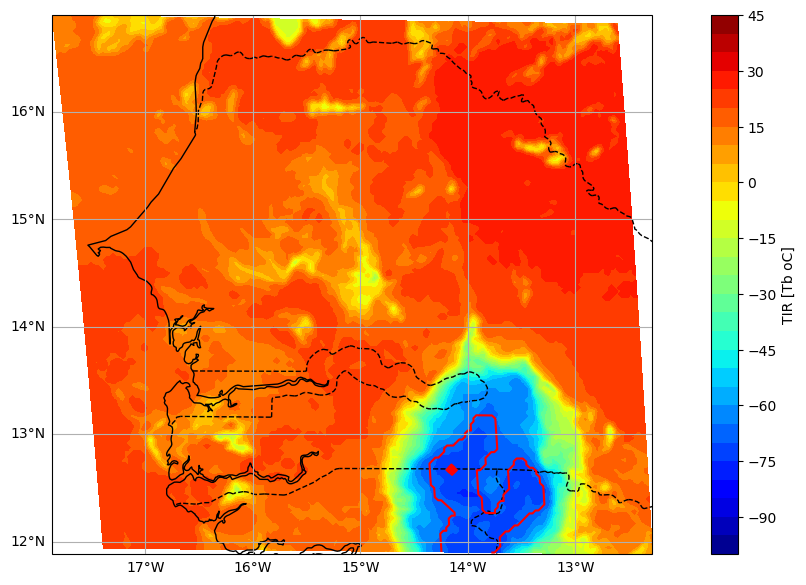

In [10]:
day = 96*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat, levels=np.arange(-100,50,5), cbar_label='TIR [Tb oC]', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [11]:
# input data- cores_t_0: 
# starting at 
num_frames= 1     #8  # previous 2 hours of images to predict in that 2 hour period
t0= 0   #1   #*4 #  15 min  later (4 frames at 15 min)
a= 45
b= 48
#cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
#cores_t_0 = cores[t0:-t0, a:,b:]
#tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
#tir_t_0 = tir[t0:-t0, a:,b:]
cores_t_0 = cores[0:-num_frames-t0, :-a,b:]
tir_t_0 = tir[0:-num_frames-t0, :-a,b:]
ind_tir = np.where(tir_t_0>-30)
tir_t_0[ind_tir] = 0
tir_t_0[np.isnan(tir_t_0)] = 0
tir_t_0 = tir_t_0/np.min(tir_t_0)

#target data
cores_t_plus_xhr = cores[t0+num_frames:,:-a,b:]
ind = np.where(cores_t_plus_xhr>0)
cores_t_plus_xhr[ind] = 1
ind_not = np.where(cores_t_plus_xhr<=0)
cores_t_plus_xhr[ind_not] = 0
print(np.unique(cores_t_plus_xhr))



[0. 1.]


In [28]:
a= 45
b= 48

In [11]:
ind_tir = np.where(tir_t_0>-30)
tir_t_0[ind_tir] = 0
tir_t_0[np.isnan(tir_t_0)] = 0
tir_t_0 = tir_t_0/np.min(tir_t_0)


In [12]:
print(np.unique(tir_t_0))


[-0.          0.3125      0.32291667  0.33333333  0.34375     0.35416667
  0.36458333  0.375       0.38541667  0.39583333  0.40625     0.41666667
  0.42708333  0.4375      0.44791667  0.45833333  0.46875     0.47916667
  0.48958333  0.5         0.51041667  0.52083333  0.53125     0.54166667
  0.55208333  0.5625      0.57291667  0.58333333  0.59375     0.60416667
  0.61458333  0.625       0.63541667  0.64583333  0.65625     0.66666667
  0.67708333  0.6875      0.69791667  0.70833333  0.71875     0.72916667
  0.73958333  0.75        0.76041667  0.77083333  0.78125     0.79166667
  0.80208333  0.8125      0.82291667  0.83333333  0.84375     0.85416667
  0.86458333  0.875       0.88541667  0.89583333  0.90625     0.91666667
  0.92708333  0.9375      0.94791667  0.95833333  0.96875     0.97916667
  0.98958333  1.        ]


In [13]:
#cores_t_plus_xhr = cores[t0+num_frames:, a:,b:]
#ind = np.where(cores_t_plus_xhr>0)
#print(np.unique(cores[:t0+num_frames,:-a,b:]))
#print(np.unique(cores[t0+num_frames:,:-a,b:]))
#print(np.unique(cores_t_plus_xhr))
#cores_t_plus_xhr.sum()
#print(cores_t_plus_xhr[ind])
#print(ind)
print(tir_t_0.shape)
print(cores_t_plus_xhr.shape)


(11711, 128, 128)
(11711, 128, 128)


NameError: name 't0' is not defined

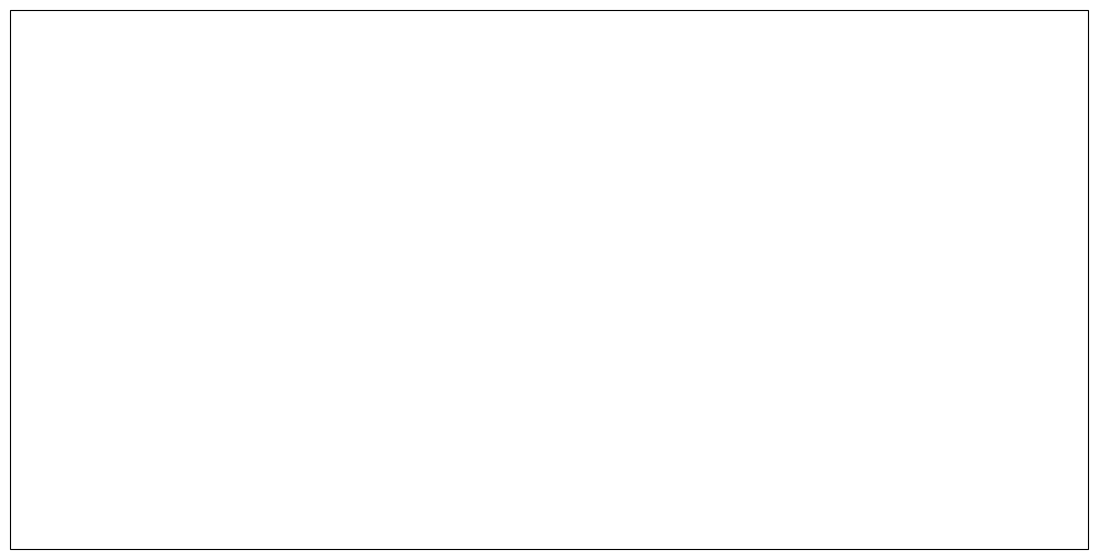

In [14]:
day = 96*19  #t0+num_frames+63  #96*19-36
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, cores_t_plus_xhr[day- (t0+num_frames),:,:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(lon[:-a,b:], lat[:-a,b:], tir[day,:-a,b:], cmap='jet')
#ax.contour(lon[:-a,b:], lat[:-a,b:], cores[day,:-a,b:], color='r')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], cbar_label='TIR [Tb oC]', cmap='jet')

#

In [9]:
# save variables 
#with open('pkl_files/WA_subdomain_cores_2hr_back.pkl', 'wb') as file: 
          #pickle.dump([cores_t_0,tir_t_0,cores_t_plus_xhr], file) 
        

In [10]:
# open a file, where you stored the pickled data
file = open('pkl_files/WA_subdomain_cores_2hr_back.pkl', 'rb')
data = pickle.load(file)
cores_t_0= data[0]
tir_t_0= data[1]
cores_t_plus_xhr= data[2]

In [15]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 1 #  core at t0-       tir at t0-x, t0, , cores
#input_shape = (image_height, image_width, num_channels)
#input_shape = (num_frames, image_height, image_width, num_channels)
# Sample data (you should replace this with your own dataset)
#num_samples = len(cores_t_plus_xhr[0,0,:])
#sequence_length = 5



In [60]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, image_height,image_width, num_channels))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=8, #64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)
x = layers.Dense(1, activation="sigmoid")(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


In [61]:
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 128, 128,   0         
                             1)]                                 
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, None, 128, 128, 8  7232      
                             )                                   
                                                                 
 batch_normalization_4 (Batc  (None, None, 128, 128, 8  32       
 hNormalization)             )                                   
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, None, 128, 128, 8  4640      
                             )                                   
                                                                 
 batch_normalization_5 (Batc  (None, None, 128, 128, 8  32 

In [42]:
num_frames= 8   #24  # hours
batch_size= int(len(cores_t_0[:,0,0])/num_frames)  # days 720 - 96 one day
val_samples= 200
x_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
y_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
x_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
y_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
                   
    
for i in range(0,batch_size-val_samples,1):  
    x_train[i,:,:,:,0]= tir_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_train[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
    
    
val_ind= (i+1)*num_frames
    
for i in range(0,val_samples,1):  
    x_val[i,:,:,:,0]= tir_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    y_val[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]

           
# normalize input data    
#x_normalize_factor = np.min(x_train)
#x_train = x_train/x_normalize_factor
#x_val = x_val/x_normalize_factor


In [43]:
print(x_train.shape)
print(x_val.shape)
#batch_size-val_samples
#batch_size

(1263, 8, 128, 128, 1)
(200, 8, 128, 128, 1)


In [62]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 10 # 20
batch_size = 4 #50# batch_size#24

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
316/316 [==============================] - 383s 1s/step - loss: 0.6328 - val_loss: 0.5626 - lr: 0.0010
Epoch 2/10
316/316 [==============================] - 382s 1s/step - loss: 0.5042 - val_loss: 0.4605 - lr: 0.0010
Epoch 3/10
316/316 [==============================] - 381s 1s/step - loss: 0.4111 - val_loss: 0.3821 - lr: 0.0010
Epoch 4/10
316/316 [==============================] - 569s 2s/step - loss: 0.3392 - val_loss: 0.3218 - lr: 0.0010
Epoch 5/10
316/316 [==============================] - 672s 2s/step - loss: 0.2836 - val_loss: 0.2755 - lr: 0.0010
Epoch 6/10
316/316 [==============================] - 672s 2s/step - loss: 0.2404 - val_loss: 0.2398 - lr: 0.0010
Epoch 7/10
316/316 [==============================] - 672s 2s/step - loss: 0.2062 - val_loss: 0.2110 - lr: 0.0010
Epoch 8/10
316/316 [==============================] - 462s 1s/step - loss: 0.1788 - val_loss: 0.1859 - lr: 0.0010
Epoch 9/10
316/316 [==============================] - 373s 1s/step - loss: 0.1549 - val_

In [22]:
#example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
#print(example.shape)
#with open('WA_subdomain_trained_model_2hr_back_15min_forward.pkl', 'wb') as file: 
 #   pickle.dump(model, file) 
        

In [23]:
#print(x_val.shape)
#print(predicted_frame.shape)
#print(np.where(all_frames>0.35))

In [63]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
# using x_val for now 
# all_frames=np.zeros((50,image_height,image_width, num_channels))

# for b in range(0,51,1):
batch_number = 0 #b #50
frames = x_val[batch_number,0:4,:,:,:] # 
original_frame_to = y_val[batch_number,2,:,:,:] # 
original_frames = y_val[batch_number,3:7,:,:,:] # 
# print(frames.shape)
# print(original_frames.shape)
# original_frames = y_val[batch_number,5:,:,:,:] # 

# Predict a new set of 4 frames.
for _ in range(4):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
    #all_frames = np.concatenate((all_frames, predicted_frame), axis=0)


1/1 [==============================] - 0s 43ms/step


In [64]:
print(frames.shape)
print(original_frames.shape)
#print(new_prediction.shape)
#print(lon[:-a,b:].shape)
#print(lat[:-a,b:].shape)
#ind = np.where(frames[24:,:,:,0]>0.25)
#print((ind))

(8, 128, 128, 1)
(4, 128, 128, 1)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


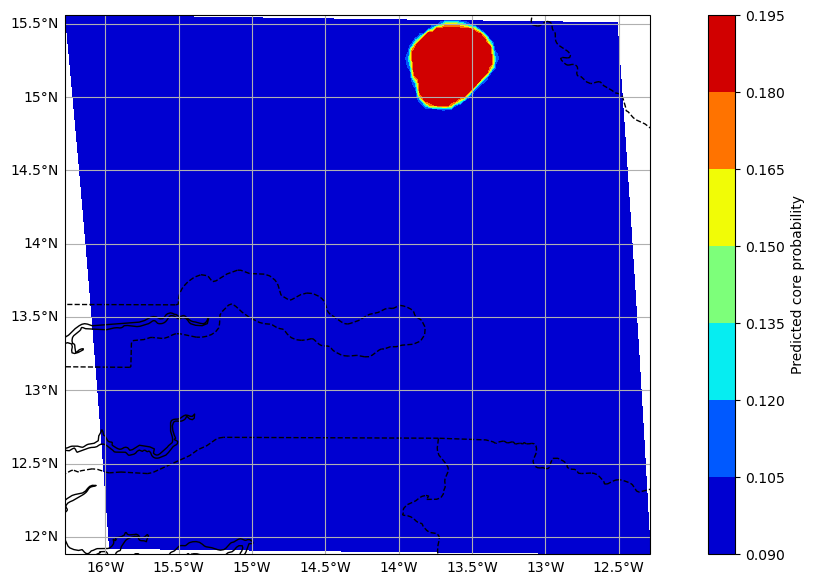

In [74]:
day = 4 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
#draw_map(ax, np.squeeze(frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.25,0.5,0.75,1], cbar_label='Predicted core probability', cmap='jet')
draw_map(ax, np.squeeze(frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=None, cbar_label='Predicted core probability', cmap='jet')

#

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


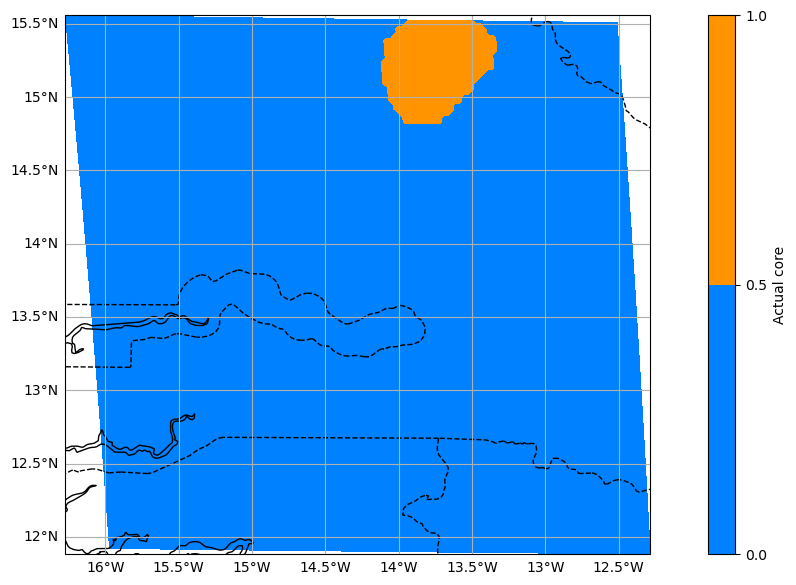

In [66]:
#day = 23 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(original_frames[0,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.5,1], cbar_label='Actual core', cmap='jet')


In [67]:
original_frame_to.shape

(128, 128, 1)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

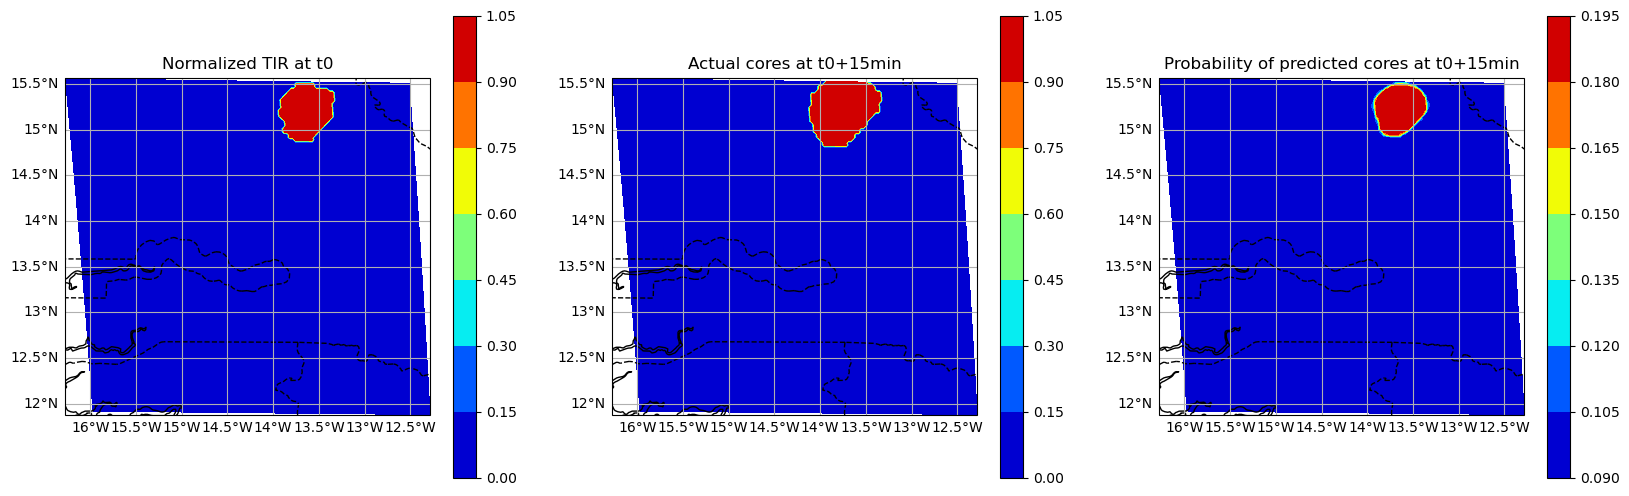

In [68]:
day = 4
data = np.zeros((3,image_height,image_width))
#data[0] = np.squeeze(frames[day-4*t0,:,:,0])
#data[0] = np.squeeze(frames[day-1,:,:,0])
data[0] = np.squeeze(original_frame_to[:,:,0])
data[1] = np.squeeze(original_frames[0,:,:,0])
data[2] = np.squeeze(frames[day,:,:,0])
#titles = ['Cores at t0-1hr', 'Cores at t0', 'Probability of cores at t0+1hr']
titles = ['Normalized TIR at t0', 'Actual cores at t0+15min', 'Probability of predicted cores at t0+15min']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.3,0.325,0.35,0.4,0.5,0.6]]#[0, 0.1, 0.2, 0.3,0.4]]

fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

#levels_custom[0]
i=0
for ax in axes:
    m= ax.contourf(lon[:-a,b:], lat[:-a,b:], data[i], transform=ccrs.PlateCarree(),cmap='jet')  # this is the actual plot
# ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(titles[i])
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')
    i=i+1
 
#plt.show()

In [69]:
def plot_maps(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    #cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')


In [70]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')


In [71]:
print(frames.shape)

(8, 128, 128, 1)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

Predicting core at 15min


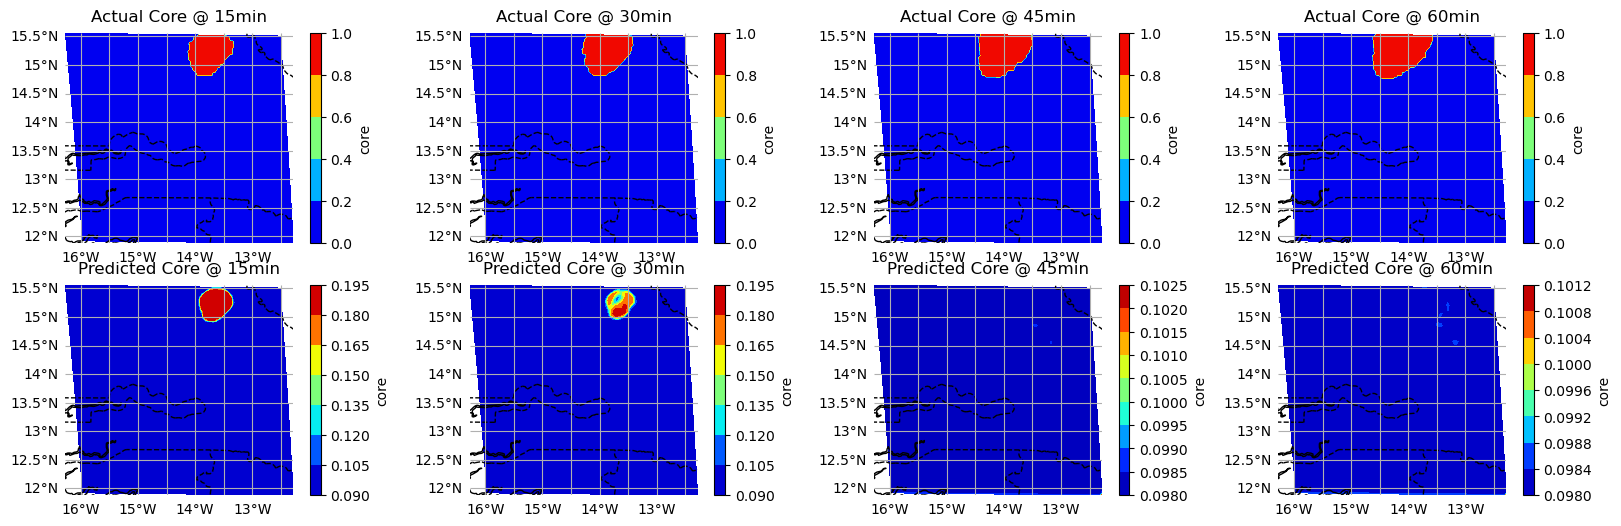

In [73]:
day = 4
data = np.zeros((day,image_height,image_width))
original = np.zeros((day,image_height,image_width))
for x in range(0,4,1):
    data[x] = np.squeeze(frames[day+x,:,:,0])
    original[x] = np.squeeze(original_frames[x,:,:,0])
    
    
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1,0.2)]#[0, 0.1, 0.2, 0.3,0.4]]
    
fig, axes = plt.subplots(2, 4, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], original[idx,:,:],  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"Actual Core @ {idx*15 + 15}min")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], data[idx,:,:],  title=None ,levels_custom= None)
    ax.set_title(f"Predicted Core @ {idx*15 + 15}min")
    ax.axis("off")

# Print information and display the figure.
print('Predicting core at 15min')
plt.show()